In [2]:
import sys
sys.path.append('../..')

import numpy as np

from olfactory_navigation.environment import Environment
from olfactory_navigation.agents import FSVI_Agent, QMDP_Agent, Infotaxis_Agent
from olfactory_navigation.agents.model_based_util.pomdp import Model
from olfactory_navigation.agents.model_based_util.belief import Belief, BeliefSet
from olfactory_navigation.simulation import run_test

from matplotlib import pyplot as plt
from matplotlib import colors, patches
from scipy.stats import multivariate_normal
from sklearn.metrics import confusion_matrix
from tqdm.auto import tqdm

In [4]:
from cupy.cuda import runtime as cuda_runtime
cuda_runtime.setDevice(0)

## Variables

In [5]:
# Space and cells
space_shape = np.array([101,101])
cells = np.array([3,3])

# Source
source_position = np.array([33,33])
source_radius = 4

## Building probabilities

In [6]:
indices = np.arange(space_shape[0])
x,y = np.meshgrid(indices, indices)
pos = np.dstack((x, y))
rv = multivariate_normal([50, 50], 50)
probability_map = rv.pdf(pos)

# Normalize to have 1 at the center
probability_map /= np.max(probability_map)

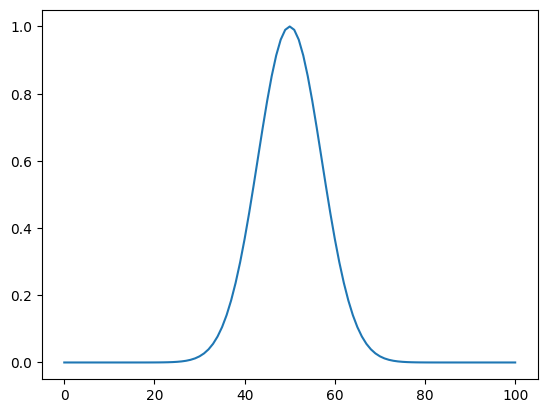

In [7]:
plt.plot(probability_map[50])

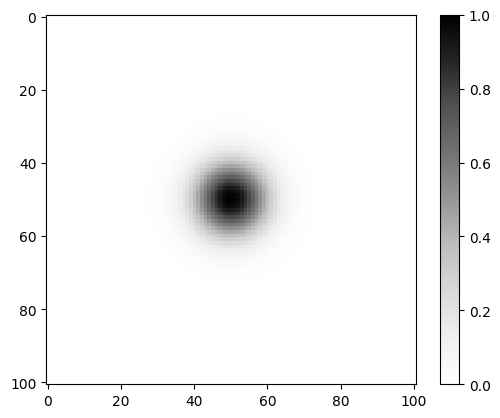

In [8]:
plt.imshow(probability_map, cmap='Greys')
plt.colorbar()

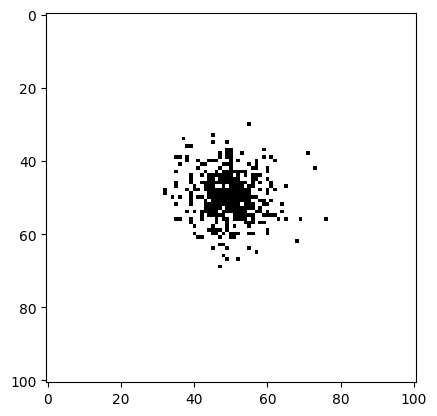

In [9]:
multiple_samples = (np.random.random((1000,101,101)) < probability_map).astype(float)

# Print sample
plt.imshow(multiple_samples[4], cmap='Greys')

## Model Definition

### Basic cells

In [10]:
def build_grid_mapping(space_shape: np.ndarray = np.array([101,101]),
                       cells: np.ndarray = np.array([3,3]),
                       source_position: np.ndarray = np.array([50,50]),
                       source_radius: int = 4
                       ) -> np.ndarray:
    # Finding the sizes of the cells
    cell_size_standard = (space_shape / cells).astype(int)
    cell_size_overflow = (space_shape % cells).astype(int)

    # Determining cell sizes
    cell_sizes = []
    for ax_cells, ax_size, ax_overflow in zip(cells, cell_size_standard, cell_size_overflow):
        sizes = np.repeat(ax_size, ax_cells)
        sizes[:int(np.floor(ax_overflow/2))] += 1
        sizes[-int(np.ceil(ax_overflow/2)):] += 1
        cell_sizes.append(sizes)

    # Finding the edges of the cells and filling a grid with ids
    cell_edges = [np.concatenate(([0], np.cumsum(ax_sizes))) for ax_sizes in cell_sizes]

    lower_bounds = np.array([ax_arr.ravel() for ax_arr in np.meshgrid(*[bounds_arr[:-1] for bounds_arr in cell_edges], indexing='ij')]).T
    upper_bounds = np.array([ax_arr.ravel() for ax_arr in np.meshgrid(*[bounds_arr[1 :] for bounds_arr in cell_edges], indexing='ij')]).T

    grid_cells = np.full(space_shape, -1)
    for i, (lower_b, upper_b) in enumerate(zip(lower_bounds, upper_bounds)):
        slices = [slice(ax_lower, ax_upper) for ax_lower, ax_upper in zip(lower_b, upper_b)]

        # Grid to cell mapping
        grid_cells[*slices] = i

    # Finding cell the replace
    source_cell_id = grid_cells[*source_position]
    source_cell = np.array(np.unravel_index(source_cell_id, cells))

    # Finding center and replacing with closest side
    source_cell_shape = np.array([sizes[int(ax_id)] for sizes, ax_id in zip(cell_sizes, source_cell)])
    source_in_source_cell = source_position - lower_bounds[source_cell_id]

    # Splitting the center cell grid into cardinal quarters
    array = np.zeros(source_cell_shape)

    # Finding indices
    indices_list = list(np.ndindex(array.shape))
    indices_array = np.array(indices_list)

    # From the indices finding the points and converting them to the imaginary grid
    points = indices_array - source_in_source_cell
    points_im = points[:,0] + (points[:,1] * 1j)

    # Shifting the points by 4 times by 90degrees and computing the angles
    shifted_points_im = points_im[:,None] * np.array([1, 1j, -1, -1j])
    angles = np.angle(shifted_points_im, deg=True)

    # Finding edge cells
    edge_cells = source_cell[None,:] + np.array([[1,0],[0,-1],[-1,0],[0,1]])
    edge_exists = np.all((edge_cells >= 0) & (edge_cells < cells), axis=1)
    edge_cells[~edge_exists] = source_cell[None,:]
    edge_cells_id = np.ravel_multi_index(edge_cells.T, cells)

    # Computing the closest quarter for each point and assigning it on the grid
    closest_quarter = np.argmin(np.abs(angles) + np.where(angles < 0, 0, 1), axis=1)
    array[*indices_array.T] = edge_cells_id[closest_quarter]
    # array[*indices_array.T] = (np.arange(4) + np.prod(cells))[closest_quarter]

    # Inserting in the grid
    source_cell_slices = [slice(ax_lower, ax_upper) for ax_lower, ax_upper in zip(lower_bounds[source_cell_id], upper_bounds[source_cell_id])]
    grid_cells[*source_cell_slices] = array

    # Spacial indices
    spacial_indices = list(np.ndindex(tuple(space_shape)))
    spacial_indices_array = np.array(spacial_indices).astype(int)

    # Indices are at source
    at_source = np.sum((source_position[None,:] - spacial_indices_array) ** 2, axis=1) <= source_radius ** 2
    grid_cells[*spacial_indices_array[at_source].T] = -1

    return grid_cells

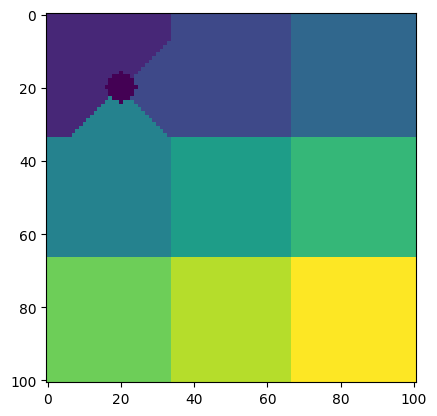

In [11]:
grid_cells = build_grid_mapping(source_position=np.array([20,20]))
# grid_cells = build_grid_mapping(cells=np.array([9,9]))
# grid_cells = build_grid_mapping()

# Visualize
plt.imshow(grid_cells)
plt.show()

### State labels

In [12]:
# Get the list of all indices
indices_list = list(np.ndindex((*cells, *cells)))

# Print the indices list
state_labels = [f's_{s_y}_{s_x}-a_{a_y}_{a_x}' for (s_y, s_x, a_y, a_x) in indices_list] + ['goal']
state_labels[:10]

['s_0_0-a_0_0',
 's_0_0-a_0_1',
 's_0_0-a_0_2',
 's_0_0-a_1_0',
 's_0_0-a_1_1',
 's_0_0-a_1_2',
 's_0_0-a_2_0',
 's_0_0-a_2_1',
 's_0_0-a_2_2',
 's_0_1-a_0_0']

### Actions

In [13]:
action_set = np.array([
    [-1,  0], # North
    [ 0,  1], # East
    [ 1,  0], # South
    [ 0, -1]  # West
])
action_labels = [
    'North',
    'East',
    'South',
    'West'
]

### Transition probabilities

In [14]:
def find_cell_centers(space_shape: np.ndarray = np.array([101,101]),
                      cells: np.ndarray = np.array([3,3])):

    # Finding the sizes of the cells
    cell_size_standard = (space_shape / cells).astype(int)
    cell_size_overflow = (space_shape % cells).astype(int)

    # Determining cell sizes
    cell_sizes = []
    for ax_cells, ax_size, ax_overflow in zip(cells, cell_size_standard, cell_size_overflow):
        sizes = np.repeat(ax_size, ax_cells)
        sizes[:int(np.floor(ax_overflow/2))] += 1
        sizes[-int(np.ceil(ax_overflow/2)):] += 1
        cell_sizes.append(sizes)

    # Finding the edges of the cells and filling a grid with ids
    cell_edges = [np.concatenate(([0], np.cumsum(ax_sizes))) for ax_sizes in cell_sizes]

    lower_bounds = np.array([ax_arr.ravel() for ax_arr in np.meshgrid(*[bounds_arr[:-1] for bounds_arr in cell_edges], indexing='ij')]).T

    cell_centers = lower_bounds + np.floor(cell_size_standard / 2).astype(int)
    return cell_centers

In [15]:
source_positions = find_cell_centers(space_shape=space_shape,
                                     cells=cells)

# Spacial indices
spacial_indices = list(np.ndindex(tuple(space_shape)))
spacial_indices_array = np.array(spacial_indices).astype(int)

# Set the transition probability matrix
cell_count = np.prod(cells)
state_count = (cell_count**2) + 1
action_count = len(action_set)
transition_probabilities = np.zeros((state_count, action_count, state_count))

for source_i, source_pos in enumerate(source_positions):
    grid_cells = build_grid_mapping(space_shape=space_shape,
                                    cells=cells,
                                    source_position=source_pos,
                                    source_radius=source_radius)
    cells_from_indices = grid_cells[*spacial_indices_array.T]

    move_probabilities = []
    for move in action_set:
        # Applying the moves to the indices
        moved_indices = spacial_indices_array + move
        moved_indices_clipped = np.clip(moved_indices, 0, space_shape-1)

        # Converting moved indices to cell indices
        cells_from_indices_after_move = grid_cells[*moved_indices_clipped.T]

        # Building a confusion matrix of the moves
        conf = confusion_matrix(cells_from_indices, cells_from_indices_after_move, labels=[-1] + list(np.arange(np.prod(cells))), normalize='true')
        move_probabilities.append(conf[:,None,:])

    # Stack probabilities
    move_probabilities = np.hstack(move_probabilities)

    # In case a cell is not used, make the transition loop on itself
    zero_move_probabilities = np.argwhere(move_probabilities.sum(axis=-1) == 0).T
    move_probabilities[zero_move_probabilities[0], zero_move_probabilities[1], zero_move_probabilities[0]] = 1.0

    # Set the values in the transition matrix
    source_slice = slice((source_i * cell_count), ((source_i + 1) * cell_count))
    transition_probabilities[source_slice, :, source_slice] = move_probabilities[1:,:,1:]
    transition_probabilities[source_slice, :, -1] = move_probabilities[1:,:,0]
    transition_probabilities[-1, :, -1] = 1.0

assert np.all(transition_probabilities.sum(axis=-1).round(8) == 1.0)

### Observations

In [14]:
threshold = 3e-6

# Compute observation matrix
if not isinstance(threshold, list):
    threshold = [threshold]

# Ensure 0.0 and 1.0 begin and end the threshold list
if threshold[0] != -np.inf:
    threshold = [-np.inf] + threshold

if threshold[-1] != np.inf:
    threshold = threshold + [np.inf]

In [15]:
agent_state_labels = [label.split('-')[1] for label in state_labels[:np.prod(cells)]]

agent_state_labels[:5]

['a_0_0', 'a_0_1', 'a_0_2', 'a_1_0', 'a_1_1']

In [16]:
#  Observation labels
observation_labels = ['nothing']
if len(threshold) > 3:
    for i,_ in enumerate(threshold[1:-1]):
        observation_labels.append(f'something_l{i}')
else:
    observation_labels.append('something')

# Adding the agent position to the oservation labels
all_observation_labels = []
for obs in observation_labels:
    for agent_state in agent_state_labels:
        all_observation_labels.append(f'{agent_state}-{obs}')

observation_labels = all_observation_labels

# Add goal
observation_labels.append('goal')

### Observation Probabilities

In [17]:
# Finding the sizes of the cells
cell_size_standard = (space_shape / cells).astype(int)
cell_size_overflow = (space_shape % cells).astype(int)

# Determining cell sizes
cell_sizes = []
for ax_cells, ax_size, ax_overflow in zip(cells, cell_size_standard, cell_size_overflow):
    sizes = np.repeat(ax_size, ax_cells)
    sizes[:int(np.floor(ax_overflow/2))] += 1
    sizes[-int(np.ceil(ax_overflow/2)):] += 1
    cell_sizes.append(sizes)

# Finding the edges of the cells and filling a grid with ids
cell_edges = [np.concatenate(([0], np.cumsum(ax_sizes))) for ax_sizes in cell_sizes]

lower_bounds = np.array([ax_arr.ravel() for ax_arr in np.meshgrid(*[bounds_arr[:-1] for bounds_arr in cell_edges], indexing='ij')]).T
upper_bounds = np.array([ax_arr.ravel() for ax_arr in np.meshgrid(*[bounds_arr[1 :] for bounds_arr in cell_edges], indexing='ij')]).T


cell_probabilities = np.full(cells, -1, dtype=float)
for cell, lower_b, upper_b in zip(list(np.ndindex(tuple(cells))), lower_bounds, upper_bounds):
    slices = [slice(ax_lower, ax_upper) for ax_lower, ax_upper in zip(lower_b, upper_b)]

    # TODO: Make it flexible to multi thresh
    cell_probabilities[*cell] = np.average(multiple_samples[:,*slices].astype(float))

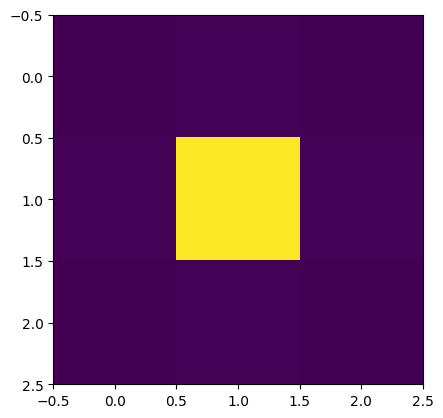

In [18]:
plt.imshow(cell_probabilities)

In [19]:
indices_array = np.array(indices_list)
relative_indices = indices_array[:,:len(cells)] - indices_array[:,len(cells):]

# Shifting the relative positions by the position of the center
center_pos = (cells / 2).astype(int)
centered_positions = relative_indices + center_pos

# Filtering to the valid centered positions
valid_positions = np.all((centered_positions >= 0) & (centered_positions < cells), axis=1)
filtered_centered_positions = centered_positions[valid_positions]
filtered_indices_array = indices_array[valid_positions]

# Gathering the cell_probabilities
odor_probabilities = np.zeros((*cells, *cells), dtype=float)
odor_probabilities[*filtered_indices_array.T] = cell_probabilities[*filtered_centered_positions.T]

In [20]:
# Generating an empty observation matrix
observations = np.zeros(((cell_count**2)+1, len(action_set), len(observation_labels)))

# Filling the "something" observations
agent_cells = indices_array[:np.prod(cells),2:]
for obs_i, agent_cell in enumerate(agent_cells):
    agent_cell_valid_indices = np.all(indices_array[:,2:] == agent_cell, axis=1)
    agent_at_source = agent_cell_valid_indices & np.all(indices_array[:,:2] == agent_cell, axis=1)
    filtered_indices = indices_array[agent_cell_valid_indices]

    # Finding and setting probabilities in the array
    probabilities = odor_probabilities[*filtered_indices.T][:,None]
    agent_cells_states = np.arange(cell_count**2)[agent_cell_valid_indices]
    observations[agent_cells_states,:,obs_i] = 1 - probabilities
    observations[agent_cells_states,:,obs_i+len(agent_cells)] = probabilities

    # Neighbouring cells when obs == source
    neighbouring_cells = agent_cell[None,:] + np.array([[1,0],[0,-1],[-1,0],[0,1]])
    neighbouring_cells_exists = np.all((neighbouring_cells >= 0) & (neighbouring_cells < cells), axis=1)
    neighbouring_cells[~neighbouring_cells_exists] = agent_cell[None,:]

    neighbouring_cells_points = np.array([[*agent_cell, *cell] for cell in neighbouring_cells])
    neighbouring_cells_indices = np.unique(np.ravel_multi_index(neighbouring_cells_points.T, (*cells, *cells)))

    state_index = np.ravel_multi_index((*agent_cell,*agent_cell), (*cells, *cells))

    observations[neighbouring_cells_indices,:,obs_i] = probabilities[obs_i]
    observations[state_index,:,obs_i] = 0.0

# Goal observations
observations[-1,:,0] = 0.0
observations[:,:,-1] = 0.0
observations[-1,:,-1] = 1.0 # Goal

# Normalization
observations /= observations.sum(axis=-1)[:,:,None]

### Model

In [21]:
len(state_labels)

82

In [29]:
model = Model(
    states = state_labels,
    actions = action_labels,
    observations = observation_labels,
    transitions = transition_probabilities,
    observation_table = observations,
    end_states = [len(state_labels)-1], # The very last state is the goal state
    # start_probabilities = start_probabilities,
    seed=12131415
)

In [28]:
transition_probabilities[0,0,82]

IndexError: index 82 is out of bounds for axis 2 with size 82

## Training Agent

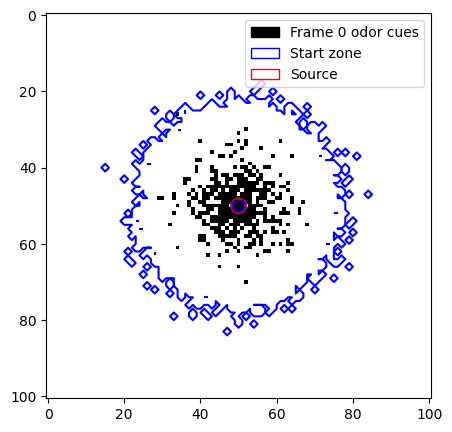

In [30]:
artificial_env  = Environment(data_file=multiple_samples,
                              data_source_position=[50, 50],
                              source_radius=2,
                              shape=[101,101],
                              boundary_condition='stop',
                              start_zone='odor_present',
                              odor_present_threshold=3e-1)

artificial_env.plot()

## FSVI agent

In [31]:
ag = FSVI_Agent(environment=artificial_env,
                threshold=3e-8,
                space_aware=True,
                spacial_subdivisions=cells,
                model=model)

In [34]:
_ = ag.train(expansions=300, use_gpu=True)

[09/06/2024, 10:28:19] MDP_policy, not provided. Solving MDP with Value Iteration...


  0%|          | 0/1000 [00:00<?, ?it/s]

Summary of Value Iteration run
  - Model: 82-state, 4-action
  - Converged in 918 iterations and 1.3397 seconds
  - Took on average 0.0015s per iteration


Expansions:   0%|          | 0/300 [00:00<?, ?it/s]

Summary of Point Based Value Iteration run
  - Model: 82 state, 4 action, 19 observations
  - Converged or stopped after 300 expansion steps and 300 backup steps.
  - Resulting value function has 1886 alpha vectors.
  - Converged in 50.5324s

  - Expand function took on average 0.0246s and yielded on average 582.91 beliefs per iteration. (0.0002s/it/belief)
  - Backup function took on average 0.1438s and yielded on average 6.27 alpha vectors per iteration. (0.0002s/it/alpha)
  - Pruning function took on average 0.0000s and yielded on average prunings of 0.00 alpha vectors per iteration.


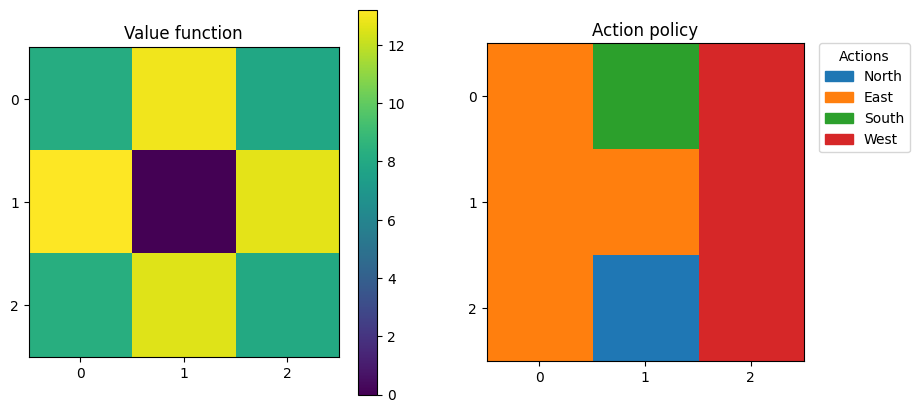

In [35]:
# CUSTOM PLOT
COLOR_LIST = [{
    'name': item.replace('tab:',''),
    'id': item,
    'hex': value,
    'rgb': [int(value.lstrip('#')[i:i + (len(value)-1) // 3], 16) for i in range(0, (len(value)-1), (len(value)-1) // 3)]
    } for item, value in colors.TABLEAU_COLORS.items()] # type: ignore

COLOR_ARRAY = np.array([c['rgb'] for c in COLOR_LIST])

# VF
vf = ag.value_function
new_shape = cells

# ! Select here which source to plot
source_policy = [1,1]
source_policy_id = np.arange(cell_count).reshape(cells)[*source_policy]
source_state_start = source_policy_id * cell_count

value_table = np.max(vf.alpha_vector_array, axis=0)[vf.model.state_grid[:,source_state_start:source_state_start+cell_count]].reshape(new_shape)
best_action_table = np.array(vf.actions)[np.argmax(vf.alpha_vector_array, axis=0)][vf.model.state_grid[:,source_state_start:source_state_start+cell_count]].reshape(new_shape)
best_action_colors = COLOR_ARRAY[best_action_table]

dimensions = new_shape

fig, (ax1,ax2) = plt.subplots(1,2, figsize=(5*2, 5), width_ratios=(0.55,0.45))

# Ticks
x_ticks = np.arange(0, dimensions[1], (1 if dimensions[1] < 10 else int(dimensions[1] / 10)))
y_ticks = np.arange(0, dimensions[0], (1 if dimensions[0] < 5 else int(dimensions[0] / 5)))

ax1.set_title('Value function')
ax1_plot = ax1.imshow(value_table)

if dimensions[0] >= dimensions[1]: # If higher than wide
    plt.colorbar(ax1_plot, ax=ax1)
else:
    plt.colorbar(ax1_plot, ax=ax1, location='bottom', orientation='horizontal')

ax1.set_xticks(x_ticks)
ax1.set_yticks(y_ticks)

ax2.set_title('Action policy')
ax2.imshow(best_action_colors)
p = [ patches.Patch(color=COLOR_LIST[int(i)]['id'], label=str(vf.model.action_labels[int(i)])) for i in vf.model.actions]
ax2.legend(handles=p, bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0., title='Actions')
ax2.set_xticks(x_ticks)
ax2.set_yticks(y_ticks)

plt.show()

## Testing agent

In [36]:
# REPLACING WITH ARTIFICAL DATA !!
env = artificial_env
# !! Remove me

In [37]:
# Taking all starting points
start_points = np.argwhere(env.start_probabilities > 0)
n = len(start_points)

In [38]:
# From the starting points, gather what cell they came from
cell_indices_array = np.array(indices_list)
start_points_cell_ids = grid_cells[*start_points.T]
start_points_cells = cell_indices_array[:cell_count][start_points_cell_ids,2:]

In [40]:
beliefs = []

for cell in start_points_cells:
    all_source_states = np.argwhere(np.all(cell_indices_array[:,2:] == cell, axis=1))[:,0]

    # Defining start probabilities
    start_prob = np.zeros((cell_count**2)+1, dtype=float)
    start_prob[all_source_states] = 1.0
    start_prob /= np.sum(start_prob)

    # Building belief point
    belief_point = Belief(model=model, values=start_prob)
    beliefs.append(belief_point)

all_beliefs = BeliefSet(model, beliefs)

In [41]:
# Initialization of the agent
ag.belief = all_beliefs

In [42]:
hist = run_test(ag,
                n=n,
                horizon=1000,
                start_points=start_points,
                environment=env,
                # skip_initialization=True,
                use_gpu=True)

Using the provided environment, not the agent environment.


  0%|          | 0/1000 [00:00<?, ?it/s]

Simulations done in 20.936s:
Simulations reached goal: 228/2347 (2119 failures (reached horizon: 2102)) (9.71% success)
 - Average step count:                 909.167 +- 275.28 (Successfull only: 92.592 +- 166.92)
 - Extra steps:                        887.540 +- 274.40 (Successful only: 73.618 +- 164.42)
 - Average discounted rewards (ADR):   0.064 +- 0.22 (Successfull only: 0.654 +- 0.32)
 - Tmin/T:                             0.088 +- 0.23 (Successful only: 0.704 +- 0.37)


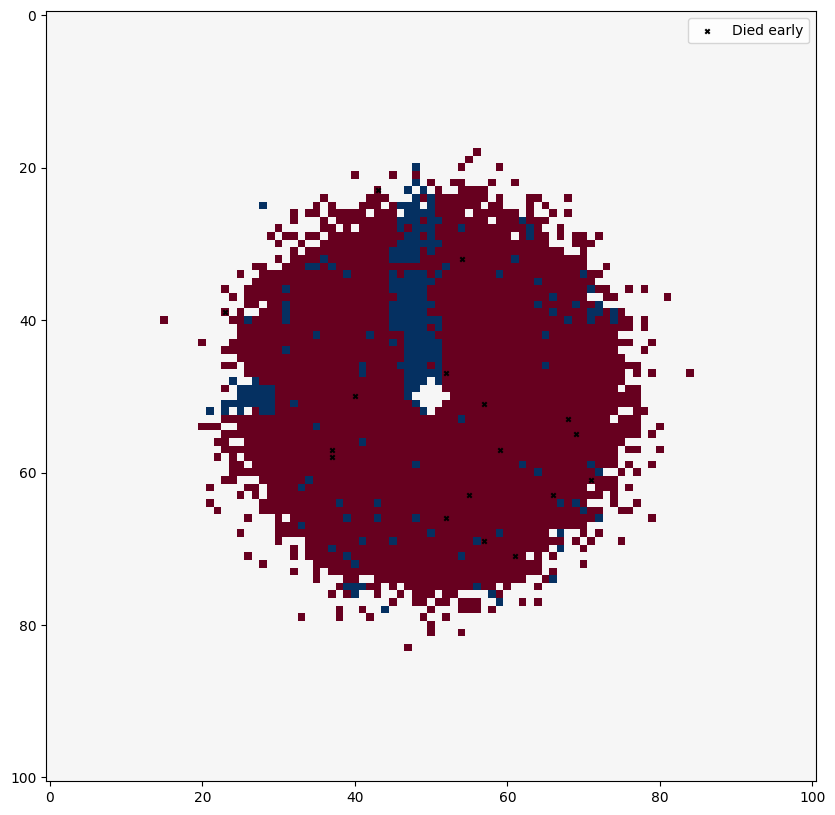

In [43]:
fig, ax = plt.subplots(1,1, figsize=(10,10))
hist.plot_successes(ax)

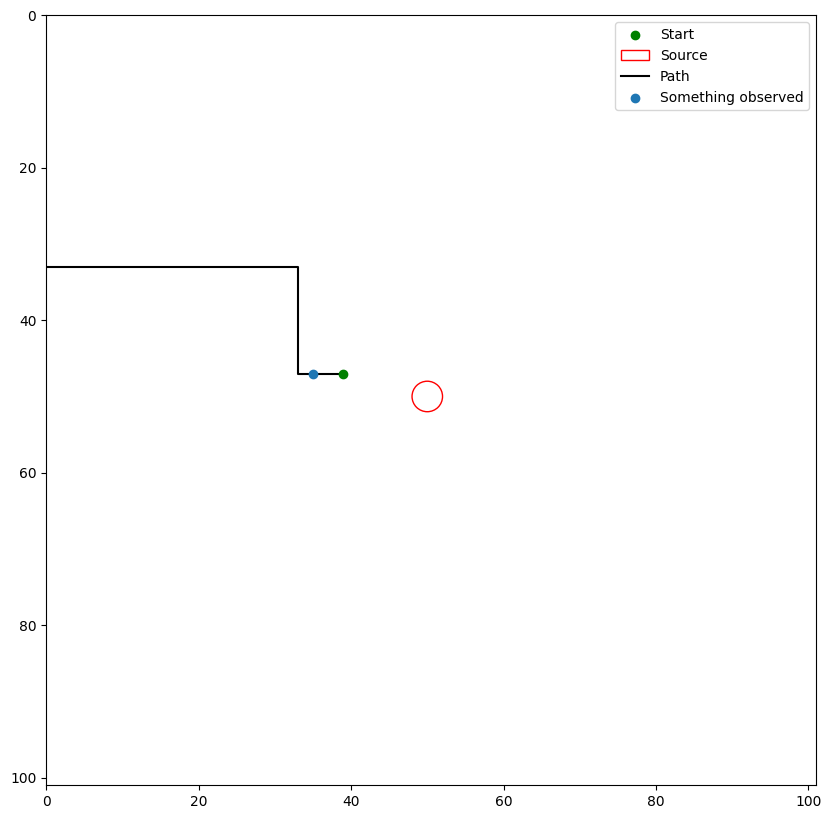

In [32]:
_, ax = plt.subplots(figsize=(10,10))
hist.plot(1000, ax= ax)